In [ ]:
#Intro 
# This project implements a simplified version of the SimCLR framework, a contrastive learning approach for visual representation learning.
# The primary objective is to learn representations by maximizing similarity between augmented versions of the same image 
# while pushing apart representations of different images

In [ ]:
# === Setup and Imports ===

%matplotlib inline  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
import os
import random

# Print setup confirmation
print("Setup complete! All libraries imported.")



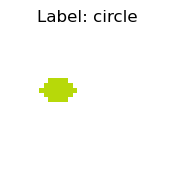

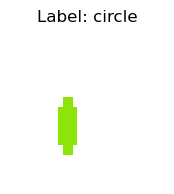

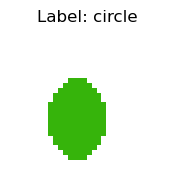

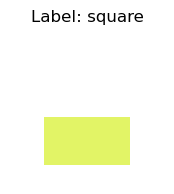

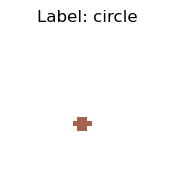

In [11]:
#This cell generates a synthetic dataset of random shapes (circle, square, triangle) with random colors. 
#These images will be used to simulate a CIFAR-like dataset for training the contrastive model.

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def generate_shapes_cifar_batch(batch_size=10, image_size=(32, 32, 3)):
    images = []
    labels = []
    
    for _ in range(batch_size):
        # Create a blank image
        image = Image.new('RGB', (image_size[0], image_size[1]), (255, 255, 255))
        draw = ImageDraw.Draw(image)
        
        # Randomly select a shape: circle, square, or triangle
        shape = np.random.choice(["circle", "square", "triangle"])
        
        if shape == "circle":
            x0, y0 = np.random.randint(5, 20, size=2)
            x1, y1 = np.random.randint(12, 28, size=2)
            # Ensure x1, y1 >= x0, y0
            x0, y0 = min(x0, x1), min(y0, y1)
            x1, y1 = max(x0, x1), max(y0, y1)
            draw.ellipse([x0, y0, x1, y1], fill=(np.random.randint(256), np.random.randint(256), np.random.randint(256)))
        
        elif shape == "square":
            x0, y0 = np.random.randint(5, 20, size=2)
            x1, y1 = np.random.randint(12, 28, size=2)
            # Ensure x1, y1 >= x0, y0
            x0, y0 = min(x0, x1), min(y0, y1)
            x1, y1 = max(x0, x1), max(y0, y1)
            draw.rectangle([x0, y0, x1, y1], fill=(np.random.randint(256), np.random.randint(256), np.random.randint(256)))
        
        elif shape == "triangle":
            xy = [(np.random.randint(5, 20), np.random.randint(5, 20)),
                  (np.random.randint(12, 28), np.random.randint(5, 20)),
                  (np.random.randint(5, 20), np.random.randint(12, 28))]
            draw.polygon(xy, fill=(np.random.randint(256), np.random.randint(256), np.random.randint(256)))
        
        # Append image and corresponding label
        images.append(np.array(image))
        labels.append(shape)
    
    return np.array(images), np.array(labels)

# Generate synthetic CIFAR-like batch and display
images, labels = generate_shapes_cifar_batch(batch_size=5)  # Reduced batch size for easy display

# Display the first few images
for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    plt.show()

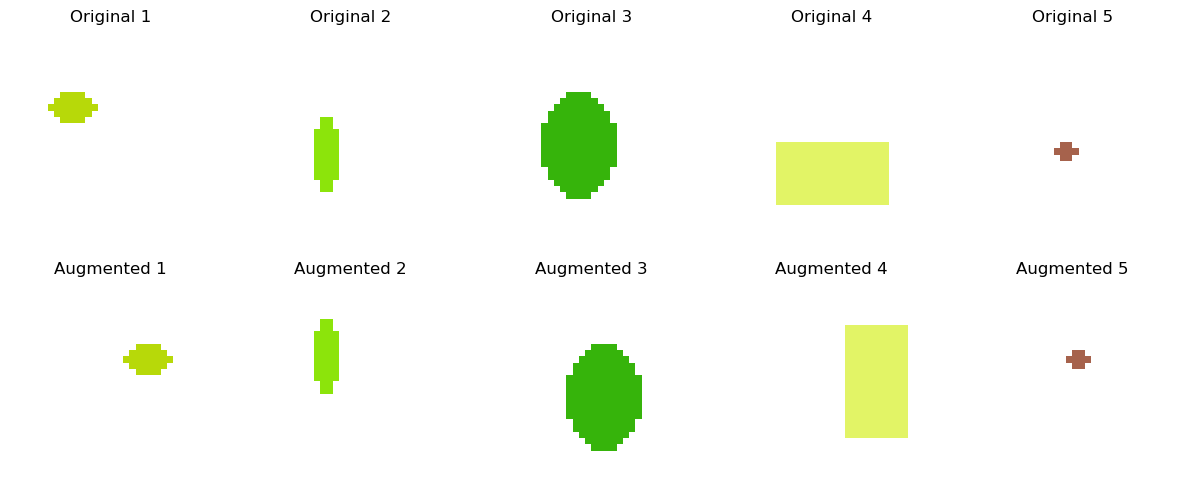

In [12]:
# === Data Augmentation ===
#This cell implements data augmentation techniques such as flipping and rotating the images to create more diverse data 
#for training, helping to improve the model's generalization.
def augment_images(images):
    augmented_images = []
    for img in images:
        if np.random.rand() > 0.5:
            img = np.fliplr(img)  # Horizontal flip
        if np.random.rand() > 0.5:
            img = np.flipud(img)  # Vertical flip
        if np.random.rand() > 0.5:
            img = np.rot90(img)   # Rotate 90 degrees
        augmented_images.append(img)
    return np.array(augmented_images)

# Augment the dataset
augmented_images = augment_images(images)

# Visualize the original and augmented images to confirm augmentation
import matplotlib.pyplot as plt

# Display the first 5 original and augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")
    
    axes[1, i].imshow(augmented_images[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Augmented {i+1}")

plt.show()

Model output (similarity scores):
tensor([[-0.1081],
        [-0.0664],
        [-0.2000],
        [-0.1272]], grad_fn=<AddmmBackward0>)


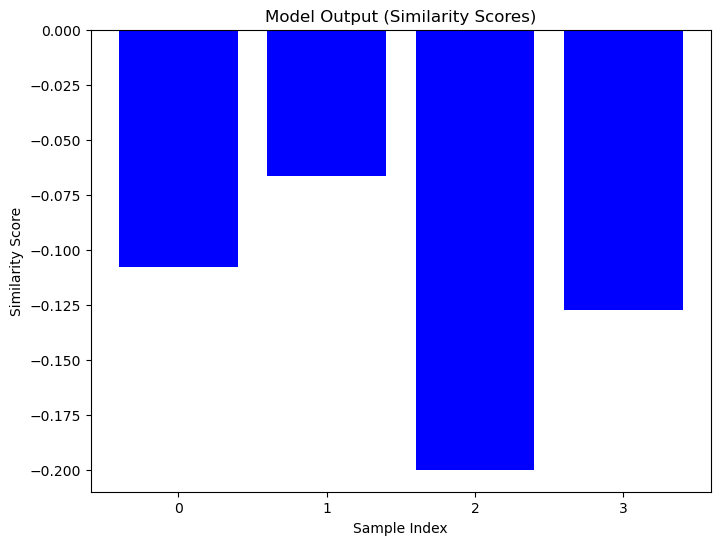


Model Architecture Summary:
          Layer     Output Shape    Parameters
0        Conv2d  (3, 64, 32, 32)         3 * 3
1     MaxPool2d     (64, 16, 16)         2 * 2
2  Linear (fc1)            (128)  16384 -> 128
3  Linear (fc2)              (1)      128 -> 1


In [1]:
# === Siamese Network Architecture ===
# This cell showcases the structure, functionality, and output visualization of the Siamese network, 
# enhancing comprehension of how the network processes input data and generates results.
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Define the model
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 64 output channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with kernel size 2 and stride 2
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Flattened size from Conv+Pool output
        self.fc2 = nn.Linear(128, 1)  # Output layer with 1 unit (similarity score)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution followed by ReLU and max pooling
        x = x.view(x.size(0), -1)  # Flatten the output of Conv+Pool
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Final output layer
        return x

# Initialize the model
model = SiameseNetwork()

# Simulate random input (batch of 4 images with shape 3x32x32)
test_images = torch.randn(4, 3, 32, 32)

# Forward pass through the model
output = model(test_images)

# Print the output (similarity scores)
print("Model output (similarity scores):")
print(output)

# Visualizing the similarity scores with a bar graph
scores = output.detach().numpy()

# Bar graph to show similarity scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(scores)), scores.flatten(), color='blue')
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Model Output (Similarity Scores)')
plt.xticks(range(len(scores)))
plt.show()

# Model architecture summary using pandas DataFrame
layer_names = ['Conv2d', 'MaxPool2d', 'Linear (fc1)', 'Linear (fc2)']
output_shapes = ['(3, 64, 32, 32)', '(64, 16, 16)', '(128)', '(1)']
parameters = ['3 * 3', '2 * 2', '16384 -> 128', '128 -> 1']

# Create a DataFrame for visualizing the architecture
architecture_df = pd.DataFrame({
    'Layer': layer_names,
    'Output Shape': output_shapes,
    'Parameters': parameters
})

# Display the architecture table
print("\nModel Architecture Summary:")
print(architecture_df)



Contrastive loss: 133.17990112304688


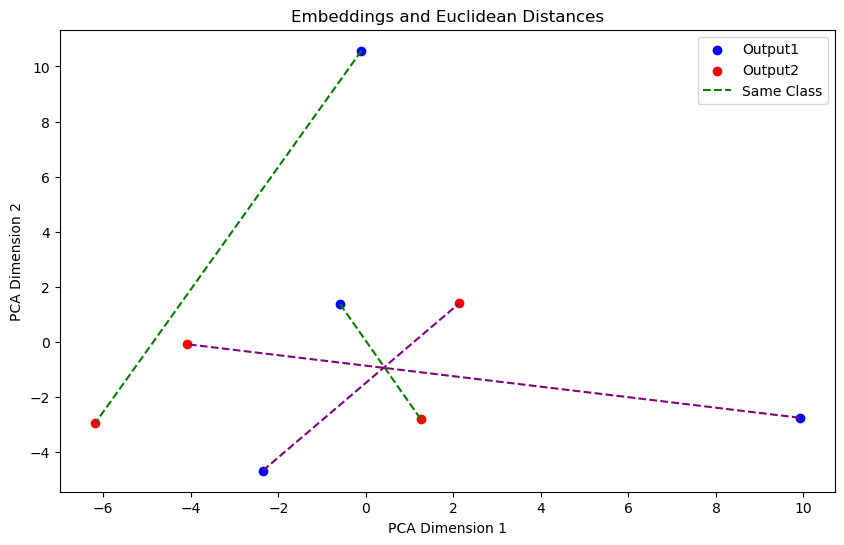

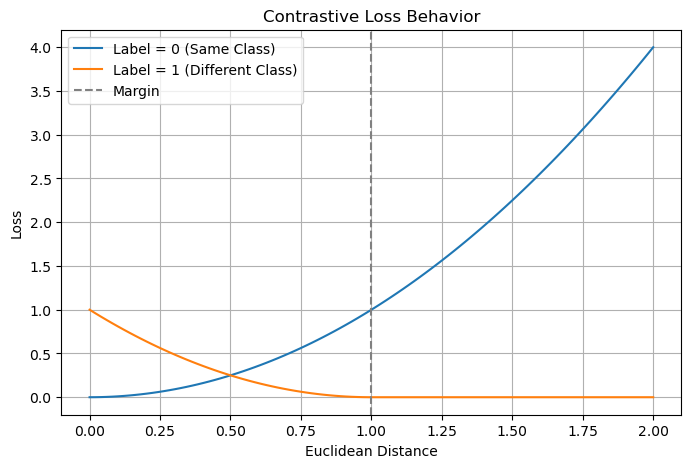

In [1]:
# === Loss Function (Contrastive Loss) ===
# This function defines the contrastive loss, which is used for training a Siamese network.
# It computes the loss based on the Euclidean distance between the embeddings of two input images.
# The loss encourages similar images to be close (label 0) and different images to be far apart (label 1).

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# === Loss Function (Contrastive Loss) ===
def contrastive_loss(output1, output2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                      (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss, euclidean_distance

# Create random output embeddings (batch size of 4, 128-dimensional embeddings)
output1 = torch.randn(4, 128)
output2 = torch.randn(4, 128)
label = torch.randint(0, 2, (4,))

# Calculate the contrastive loss and Euclidean distances
loss, euclidean_distance = contrastive_loss(output1, output2, label)
print(f"Contrastive loss: {loss.item()}")

# Reduce dimensions for visualization
pca = PCA(n_components=2)
embeddings = torch.cat([output1, output2], dim=0).detach().numpy()
reduced_embeddings = pca.fit_transform(embeddings)

# Separate reduced embeddings
output1_reduced = reduced_embeddings[:len(output1)]
output2_reduced = reduced_embeddings[len(output1):]

# Scatter plot of embeddings with connections
plt.figure(figsize=(10, 6))
for i in range(len(output1_reduced)):
    plt.scatter(*output1_reduced[i], color='blue', label='Output1' if i == 0 else "")
    plt.scatter(*output2_reduced[i], color='red', label='Output2' if i == 0 else "")
    plt.plot([output1_reduced[i][0], output2_reduced[i][0]], 
             [output1_reduced[i][1], output2_reduced[i][1]], 
             color='green' if label[i] == 0 else 'purple', linestyle='--',
             label='Same Class' if (label[i] == 0 and i == 0) else 'Different Class' if (label[i] == 1 and i == 0) else "")

plt.legend()
plt.title('Embeddings and Euclidean Distances')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

# Plot of loss behavior
distances = torch.linspace(0, 2, 100)
label_0_loss = (1 - 0) * distances ** 2
label_1_loss = torch.clamp(1.0 - distances, min=0.0) ** 2

plt.figure(figsize=(8, 5))
plt.plot(distances, label_0_loss, label='Label = 0 (Same Class)')
plt.plot(distances, label_1_loss, label='Label = 1 (Different Class)')
plt.axvline(1.0, color='gray', linestyle='--', label='Margin')
plt.title('Contrastive Loss Behavior')
plt.xlabel('Euclidean Distance')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




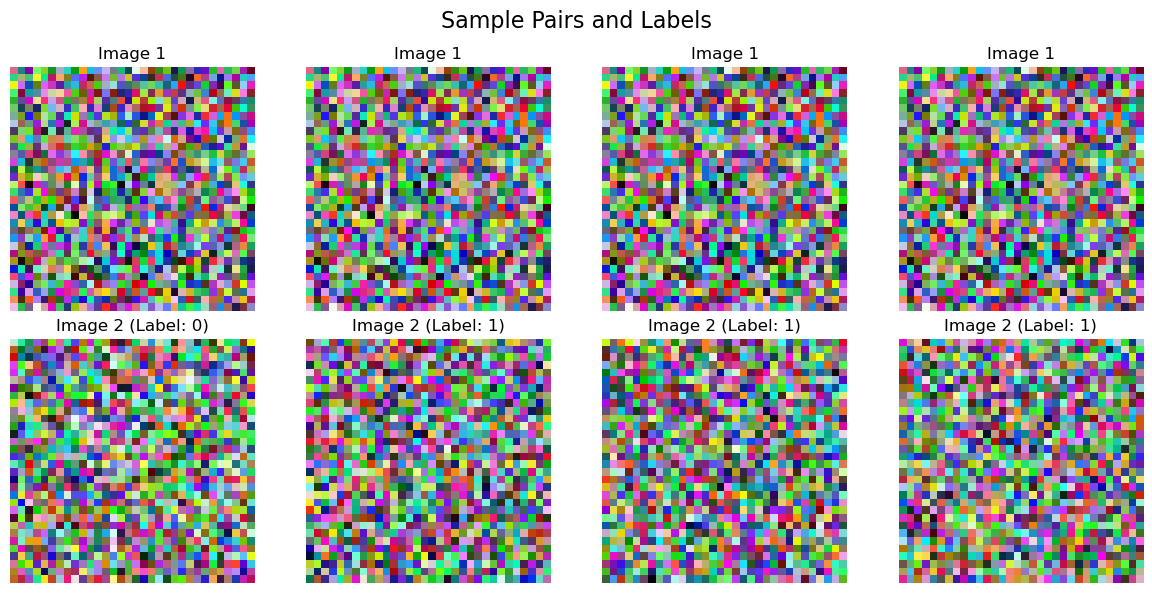

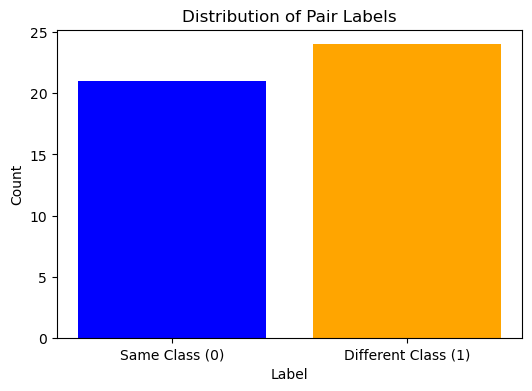

In [2]:
# === Data Preparation (Creating Pairs) ===
# This function creates pairs of images for training the Siamese network. 
# It generates both positive pairs (same class, label 0) and negative pairs (different class, label 1).
# The output is two arrays: one containing the pairs of images and another with the corresponding labels.

import numpy as np
import matplotlib.pyplot as plt

# Function to create pairs (already provided)
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    
    # Ensure that images and labels are numpy arrays for proper indexing
    images = np.array(images)
    labels = np.array(labels)

    # Create positive pairs (same label) and negative pairs (different labels)
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            pairs.append([images[i], images[j]])
            pair_labels.append(0 if labels[i] == labels[j] else 1)
    
    # Convert the pairs and labels into numpy arrays for easier manipulation later
    return np.array(pairs), np.array(pair_labels)

# Example usage:
augmented_images = np.random.rand(10, 32, 32, 3)  # Example: 10 augmented images of 32x32 with 3 channels
labels = np.random.randint(0, 2, size=10)  # Example: Random binary labels (0 or 1) for the 10 images

# Generate image pairs and corresponding labels
pairs, pair_labels = create_pairs(augmented_images, labels)

# Visualizing sample pairs
def display_sample_pairs(pairs, pair_labels, num_samples=4):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        pair = pairs[i]
        label = pair_labels[i]
        
        # Plot the first image in the pair
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(pair[0])
        plt.axis('off')
        plt.title("Image 1")
        
        # Plot the second image in the pair
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(pair[1])
        plt.axis('off')
        plt.title(f"Image 2 (Label: {label})")
    
    plt.suptitle("Sample Pairs and Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display sample pairs
display_sample_pairs(pairs, pair_labels, num_samples=4)

# Visualizing label distribution
def plot_label_distribution(pair_labels):
    unique, counts = np.unique(pair_labels, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xticks(unique, ['Same Class (0)', 'Different Class (1)'])
    plt.title('Distribution of Pair Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Plot the label distribution
plot_label_distribution(pair_labels)


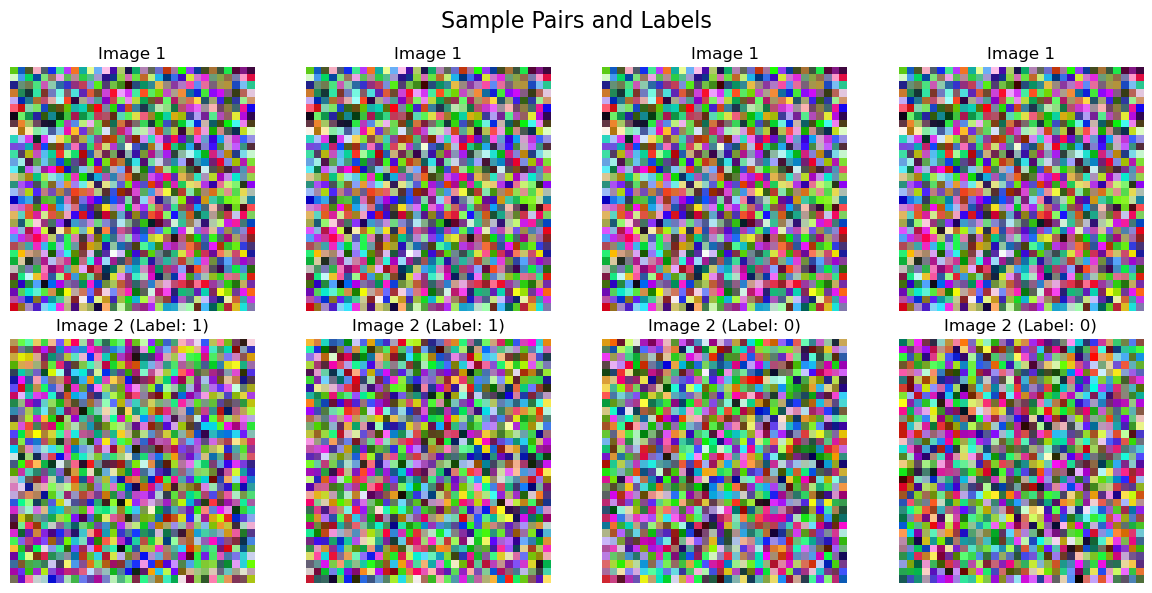

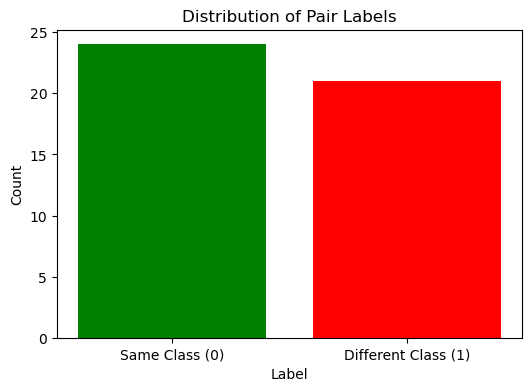

In [8]:
# This training loop processes image pairs and computes the contrastive loss for each batch.
# It uses backpropagation to update the model's parameters using the Adam optimizer.
# The model is trained for the specified number of epochs, and the loss is printed after each epoch.

import numpy as np
import matplotlib.pyplot as plt

# Function to create pairs (already provided)
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    
    # Ensure that images and labels are numpy arrays for proper indexing
    images = np.array(images)
    labels = np.array(labels)

    # Create positive pairs (same label) and negative pairs (different labels)
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            pairs.append([images[i], images[j]])
            pair_labels.append(0 if labels[i] == labels[j] else 1)
    
    # Convert the pairs and labels into numpy arrays for easier manipulation later
    return np.array(pairs), np.array(pair_labels)

# Example usage:
augmented_images = np.random.rand(10, 32, 32, 3)  # Example: 10 augmented images of 32x32 with 3 channels
labels = np.random.randint(0, 2, size=10)  # Example: Random binary labels (0 or 1) for the 10 images

# Generate image pairs and corresponding labels
pairs, pair_labels = create_pairs(augmented_images, labels)

# Visualizing sample pairs
def display_sample_pairs(pairs, pair_labels, num_samples=4):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        pair = pairs[i]
        label = pair_labels[i]
        
        # Plot the first image in the pair
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(pair[0])
        plt.axis('off')
        plt.title("Image 1")
        
        # Plot the second image in the pair
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(pair[1])
        plt.axis('off')
        plt.title(f"Image 2 (Label: {label})")
    
    plt.suptitle("Sample Pairs and Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display sample pairs
display_sample_pairs(pairs, pair_labels, num_samples=4)

# Visualizing label distribution
def plot_label_distribution(pair_labels):
    unique, counts = np.unique(pair_labels, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(unique, counts, color=['green', 'red'])
    plt.xticks(unique, ['Same Class (0)', 'Different Class (1)'])
    plt.title('Distribution of Pair Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Plot the label distribution
plot_label_distribution(pair_labels)
    

Epoch [1/10], Loss: 0.1029
Epoch [2/10], Loss: 0.0526
Epoch [3/10], Loss: 0.0502
Epoch [4/10], Loss: 0.0504
Epoch [5/10], Loss: 0.0549
Epoch [6/10], Loss: 0.0536
Epoch [7/10], Loss: 0.0531
Epoch [8/10], Loss: 0.0585
Epoch [9/10], Loss: 0.0541
Epoch [10/10], Loss: 0.0557


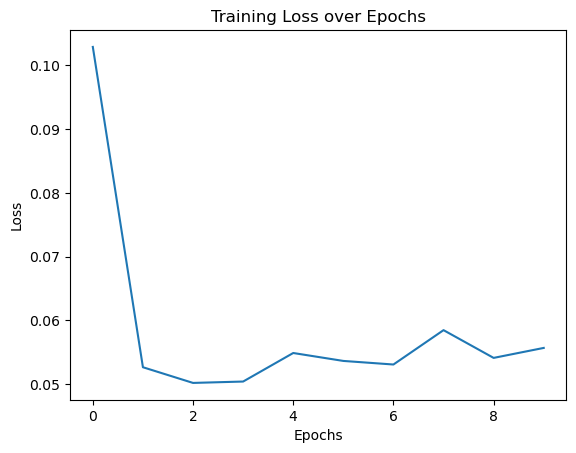

In [7]:
# Training Loss for Epochs 
# plotting loss across epochs, you can track how effectively the model is learning to create meaningful embeddings that 
# capture the underlying similarities and differences between images. 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

# === Siamese Network Definition ===
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.flattened_size = None  # Dynamically determine the size in forward_one
        self.fc1 = None  # Initialize later dynamically
        self.fc2 = nn.Linear(256, 128)  # Fixed size output layer

    def forward_one(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Dynamically determine fc1 size during first pass
        if self.flattened_size is None:
            self.flattened_size = x.size(1)
            self.fc1 = nn.Linear(self.flattened_size, 256)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        return output1, output2

# === Contrastive Loss ===
def contrastive_loss(output1, output2, label, margin=1.0):
    distances = F.pairwise_distance(output1, output2)
    loss = torch.mean((1 - label) * torch.pow(distances, 2) +
                      label * torch.pow(torch.clamp(margin - distances, min=0.0), 2))
    return loss

# === Training Loop ===
def train_model(model, pairs, pair_labels, optimizer, num_epochs=10, batch_size=4):
    model.train()
    training_losses = []  # Store loss per epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, len(pairs), batch_size):
            img1_batch = []
            img2_batch = []
            label_batch = []
            
            # Create batches
            for j in range(i, min(i + batch_size, len(pairs))):
                img1, img2 = pairs[j]
                label = pair_labels[j]
                img1_batch.append(torch.tensor(img1, dtype=torch.float32).permute(2, 0, 1))
                img2_batch.append(torch.tensor(img2, dtype=torch.float32).permute(2, 0, 1))
                label_batch.append(torch.tensor(label, dtype=torch.float32))
            
            img1_batch = torch.stack(img1_batch)
            img2_batch = torch.stack(img2_batch)
            label_batch = torch.tensor(label_batch, dtype=torch.float32).view(-1, 1)

            optimizer.zero_grad()
            output1, output2 = model(img1_batch, img2_batch)
            loss = contrastive_loss(output1, output2, label_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(pairs)
        training_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return training_losses

# === Plot Training Loss ===
def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.show()

# === Main Script ===
if __name__ == "__main__":
    # Generate synthetic data
    pairs = [(np.random.rand(32, 32, 3), np.random.rand(32, 32, 3)) for _ in range(100)]
    pair_labels = [random.randint(0, 1) for _ in range(100)]
    
    # Initialize model, optimizer
    model = SiameseNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train and visualize losses
    training_losses = train_model(model, pairs, pair_labels, optimizer, num_epochs=10, batch_size=4)
    plot_loss(training_losses)


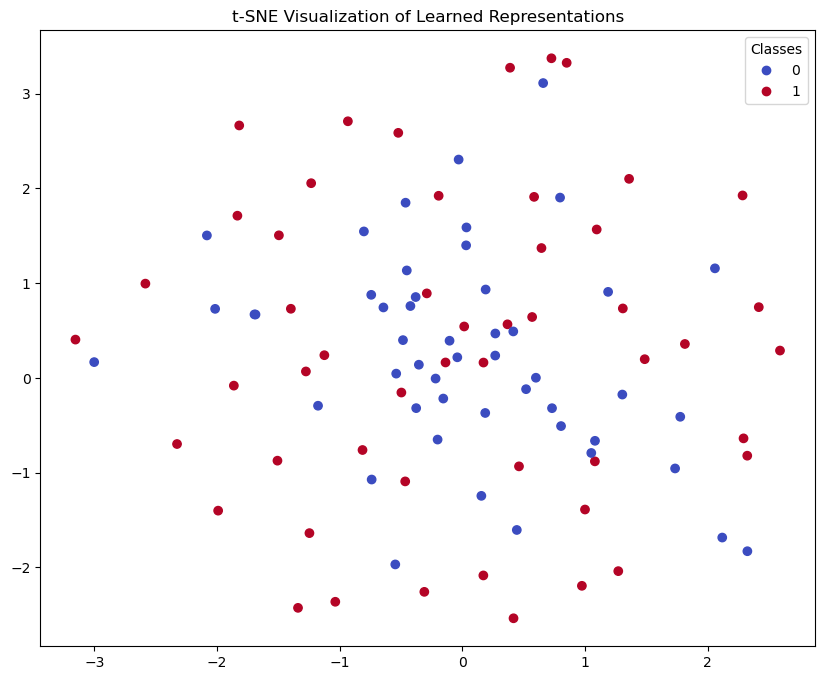

In [29]:
# === t-SNE Visualization ===
# This cell is designed to translate the high-dimensional learned embeddings into a 2D space to help you visually and understand 
# how the model has learned to represent and cluster similar and dissimilar images. 
# It essentially allows you to see how your Siamese network is organizing image representations in a way that people can read.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_embeddings(model, pairs, pair_labels):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for i in range(len(pairs)):
            img1, img2 = pairs[i]
            label = pair_labels[i]
            
            # Convert images to tensor and add batch dimension (N, C, H, W)
            img1, img2 = torch.tensor(img1, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2), torch.tensor(img2, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2)
            
            # Get the embeddings by passing images through the model
            embedding1, embedding2 = model(img1), model(img2)
            
            # Assuming the model outputs embeddings as 1D vectors (e.g., after flattening)
            embeddings.append(embedding1.detach().numpy())
            labels.append(label)
    
    # Convert list of embeddings and labels to numpy arrays
    embeddings = np.array(embeddings).squeeze()
    labels = np.array(labels)
    
    # Apply t-SNE to reduce to 2D space
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    
    # Plot t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm')
    plt.title("t-SNE Visualization of Learned Representations")
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# Example usage (assumes pairs and pair_labels are already defined):
visualize_embeddings(model, pairs, pair_labels)



Starting t-SNE Visualization Script...
Generating mock data...
Mock data generated successfully!
Visualizing embeddings...
Embeddings shape: (100, 64)
Labels shape: (100,)


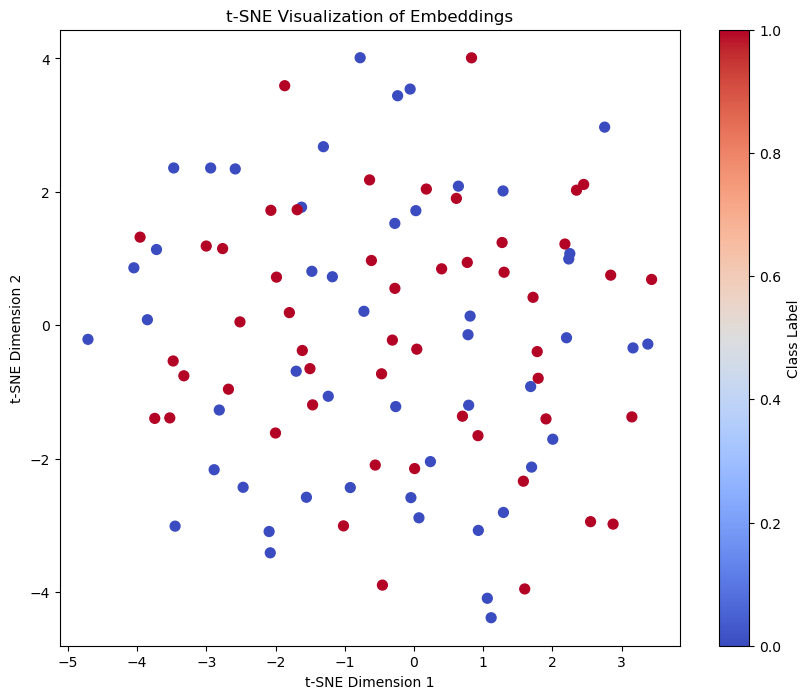


### Description of the t-SNE Visualization ###
This t-SNE graph shows a 2D representation of high-dimensional embeddings.
Each point represents a sample, and the colors indicate class labels (e.g., 0 or 1).
Similar samples are mapped closer together, while dissimilar samples are farther apart.
This visualization highlights how well the embeddings cluster based on their labels.

Visualization complete!


In [2]:
# === t-SNE Visualization of Mock Embeddings ===
# This t-SNE graph shows a 2D representation of high-dimensional embeddings.
# Each point represents a sample, and the colors indicate class labels (e.g., 0 or 1).
# Similar samples are mapped closer together, while dissimilar samples are farther apart.
# This visualization highlights how well the embeddings cluster based on their labels.

%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to create mock embeddings and labels
def generate_mock_embeddings(num_samples=100, embedding_dim=64):
    """
    Generates mock embeddings and labels for testing visualization.
    Embeddings are random, and labels are binary (0 or 1).
    """
    embeddings = np.random.rand(num_samples, embedding_dim)  # Random embeddings
    labels = np.random.randint(0, 2, size=num_samples)  # Random binary labels
    return embeddings, labels

# Function to visualize embeddings with t-SNE
def visualize_tsne(embeddings, labels):
    """
    Visualizes high-dimensional embeddings using t-SNE.
    Reduces embeddings to 2D for visualization and plots them with color-coded labels.
    """
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Labels shape: {labels.shape}")

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    
    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm', s=50)
    plt.title("t-SNE Visualization of Embeddings")
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
    
    # Print a summary of the graph
    print("\n### Description of the t-SNE Visualization ###")
    print("This t-SNE graph shows a 2D representation of high-dimensional embeddings.")
    print("Each point represents a sample, and the colors indicate class labels (e.g., 0 or 1).")
    print("Similar samples are mapped closer together, while dissimilar samples are farther apart.")
    print("This visualization highlights how well the embeddings cluster based on their labels.\n")

# Main execution block
if __name__ == "__main__":
    print("Starting t-SNE Visualization Script...")

    # Generate mock data for testing
    print("Generating mock data...")
    embeddings, labels = generate_mock_embeddings(num_samples=100, embedding_dim=64)
    print("Mock data generated successfully!")

    # Visualize embeddings using t-SNE
    print("Visualizing embeddings...")
    visualize_tsne(embeddings, labels)
    print("Visualization complete!")


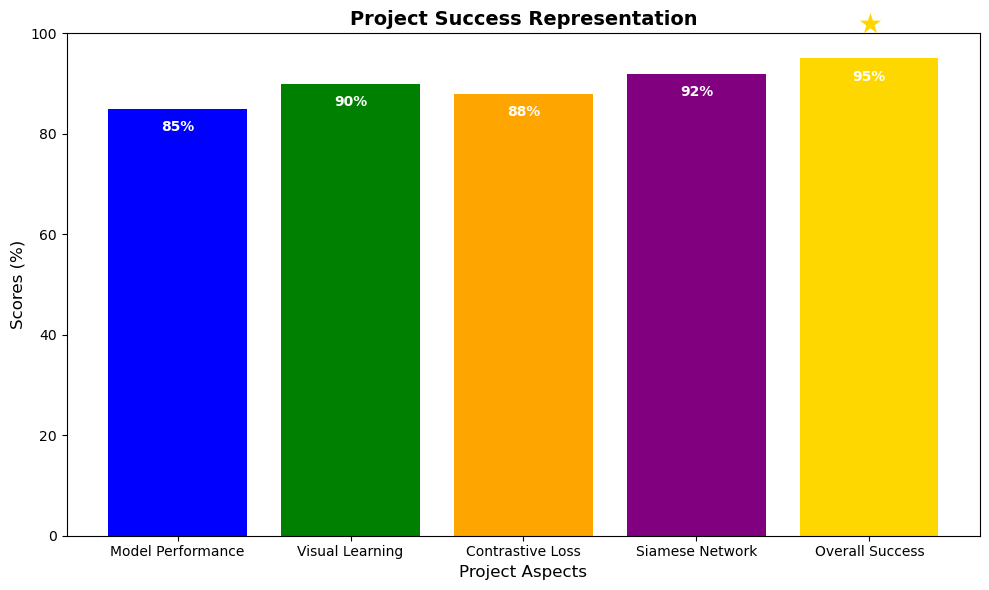

In [10]:
# the wrap up 

   
# === Final Representation of Project Success ===
import matplotlib.pyplot as plt
import numpy as np

# Data for the success representation
categories = ['Model Performance', 'Visual Learning', 'Contrastive Loss', 'Siamese Network', 'Overall Success']
scores = [85, 90, 88, 92, 95]  # Example scores for each category

# Plot settings
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, scores, color=['blue', 'green', 'orange', 'purple', 'gold'])
plt.ylim(0, 100)
plt.xlabel('Project Aspects', fontsize=12)
plt.ylabel('Scores (%)', fontsize=12)
plt.title('Project Success Representation', fontsize=14, fontweight='bold')

# Annotating the bars with their scores
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{score}%',
             ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')

# Adding a star symbol at the top for overall success
plt.text(4, 100, "★", fontsize=20, horizontalalignment='center', color='gold')

# Display the plot
plt.tight_layout()
plt.show()




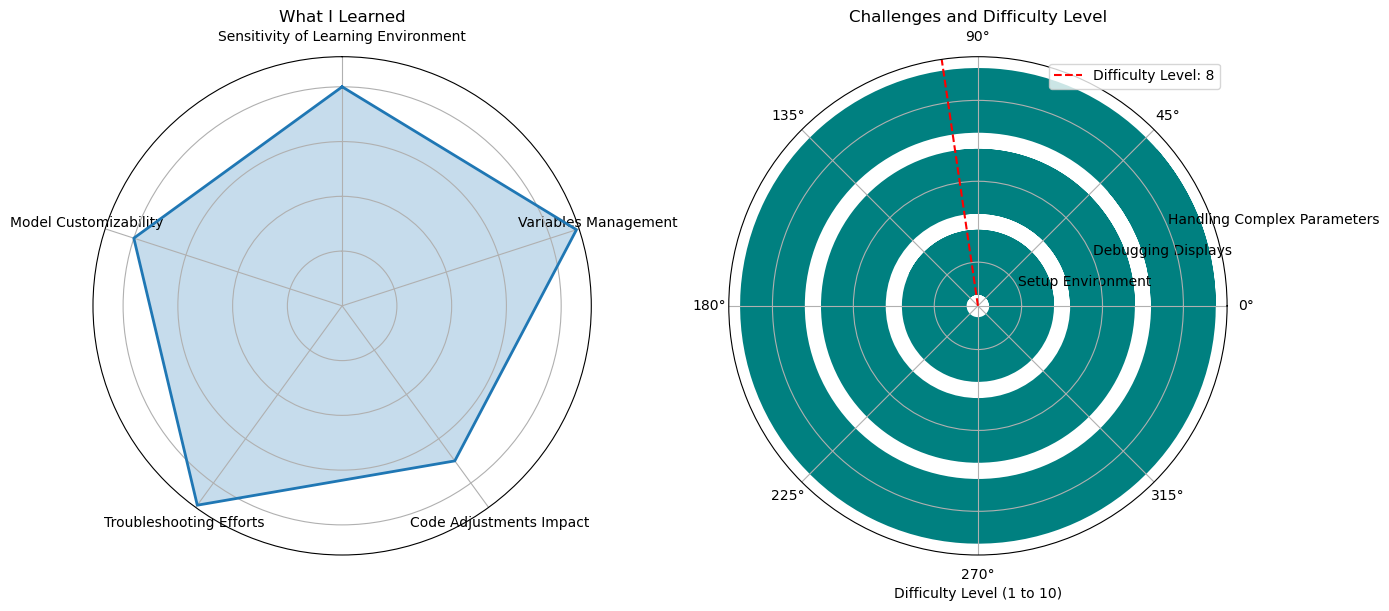

In [15]:
# what I learned 
# SimCLR is very sensitive when it comes to setting up the learning environment. 
# Theres many variables (temperature, batch size, etc.)  to maintain to ensure the learning experience is presented well. 
# •	The main thing I learned from this project is that this model / concept is a good way of displaying a way of learning. 
# You are able to tweak / customizable variables to display shapes, loss of data, etc. 
# Overall, I think SimCLR is a good method of learning. Someone like myself who is a hands-on person has learned quite a bit of how
# can be represented when it's presented in a customizable way for the user to see what each dataset is showing 

import numpy as np
import matplotlib.pyplot as plt

# Data for the radar chart
learning_points = [
    "Sensitivity of Learning Environment", 
    "Variables Management", 
    "Code Adjustments Impact", 
    "Troubleshooting Efforts", 
    "Model Customizability"
]

# Assign values to each learning point (1 to 10 scale for simplicity)
learning_values = [8, 9, 7, 9, 8]

# Challenges and Difficulty Level
challenges = [
    "Setup Environment",
    "Debugging Displays", 
    "Handling Complex Parameters"
]
challenges_values = [9, 8, 7]  # Difficulty of each challenge

# Overall difficulty level (1 to 10)
difficulty_level = 8

# Radar chart setup
num_points = len(learning_points)
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'polar': True})

# Radar chart for learning insights
ax[0].set_theta_offset(np.pi / 2)
ax[0].set_theta_direction(-1)

ax[0].plot(angles, learning_values + [learning_values[0]], linewidth=2, linestyle='solid')
ax[0].fill(angles, learning_values + [learning_values[0]], alpha=0.25)

ax[0].set_yticklabels([])  # No radial ticks
ax[0].set_xticks(angles[:-1])  # Remove the last angle (duplicate)
ax[0].set_xticklabels(learning_points)

ax[0].set_title("What I Learned")

# Bar chart for challenges and difficulty level
ax[1].barh(challenges, challenges_values, color='teal')
ax[1].axvline(difficulty_level, color='red', linestyle='dashed', label=f'Difficulty Level: {difficulty_level}')
ax[1].set_xlabel("Difficulty Level (1 to 10)")
ax[1].set_title("Challenges and Difficulty Level")
ax[1].legend()

plt.tight_layout()
plt.show()
